# Meters

Every now and then I go down into the basement and note the values on my watermeter, gasmeter and electricity meter. That last one has a day and a night counter, which is because electrity is cheaper at night. You can find this data in the "../files/Meters.ods". (It's a LibreOffice-spreadsheet.)

Start by loading the data. It's in ODS-format (not csv), so you may need to install the library first. Add an additional code block if you still need it.

In [ ]:
# !pip install odfpy

In [1]:

import pandas as pd

bad_df = pd.read_excel("../files/Meters.ods", usecols="A:C", decimal=",", thousands=".", header = 0, names=["What", "Date", "Value"])

bad_df['What'] = bad_df['What'].replace('EL.Dag', 'EL.Day')
bad_df['What'] = bad_df['What'].replace('EL.Nacht', 'EL.Night')

bad_df.head()

,What,Date,Value
0,EL.Day,2015-07-27,6192.0
1,Gas,2015-07-27,4627.0
2,EL.Night,2015-07-27,7689.0
3,EL.Day,2017-02-07,10394.0
4,Gas,2017-02-07,6209.0


There is a small problem with this data: In stead of making the following spreadsheet:

![](../files/2023-10-04-16-46-45.png)

I made the following sheet:

![](../files/2023-10-04-16-47-16.png)

But the first one would have been much nicer. Going form the good version to the bad version would be "[melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)", the one we want is "[pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot.html)".

In [2]:
# DELETE
df = bad_df.pivot(index="Date", columns="What", values="Value")

df.head()

What,EL.Day,EL.Night,Gas,Water
Date,,,,
2015-07-27,6192.0,7689.0,4627.000,NaN
2017-02-07,10394.0,12498.0,6209.000,NaN
2018-02-10,13592.0,15848.0,7258.000,NaN
2019-02-10,14270.1,18047.0,8275.484,395.004
2019-07-22,13728.7,18561.7,8630.134,425.015


Do you feel a line graph coming up? Because I sure do!

<Axes: xlabel='Date'>

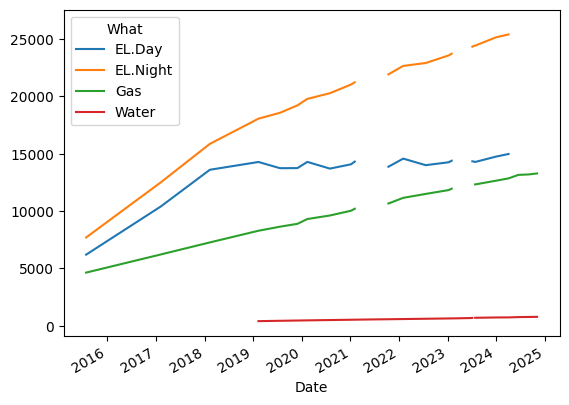

In [3]:
#DELETE
df.plot()

Can you spot the installation of my solar panels? And when I set up my pool? I'm guessing yes on the solar panels and no on the pool. If you had graphed the water separately you would have.

Could you graph water, gas and electricity in the same graph with [different scale](https://stackabuse.com/matplotlib-plot-multiple-line-plots-same-and-different-scales/) for water?

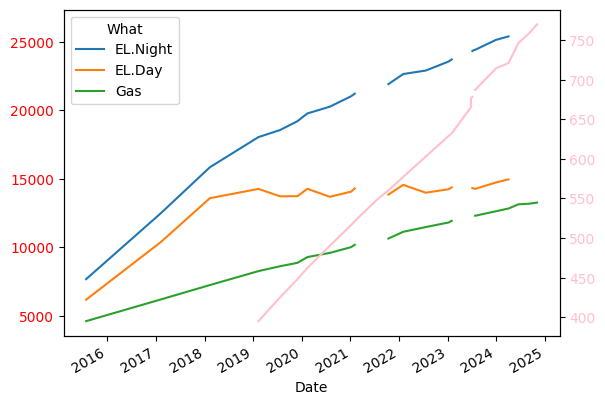

In [4]:
# DELETE

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df[["EL.Night", "EL.Day", "Gas"]].plot(ax=ax)
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
df.Water.plot(ax=ax2, color='pink')
ax2.tick_params(axis='y', labelcolor='pink')

plt.show()


The good news is that our date has now automatically been stored as a date in the index. That means we can simply select all measurements for 2021.

In [5]:
df[df.index.year == 2021]

What,EL.Day,EL.Night,Gas,Water
Date,,,,
2021-01-05,14066.9,21021.8,10020.239,516.256
2021-02-02,14304.9,21213.9,10193.987,521.430
2021-07-20,NaN,NaN,NaN,548.667
2021-10-13,13857.5,21911.0,10650.640,560.322


And had we had more data, that would have made for some nice plots.

# Filling values

A couple of different filling methods are possible for NaN-values in time series:

![](../files/2023-10-05-14-29-27.png)

Let's try them out! Forward and backward fill are [easy](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). The differences are best observed when you only plot the gas usage.

<Axes: xlabel='Date'>

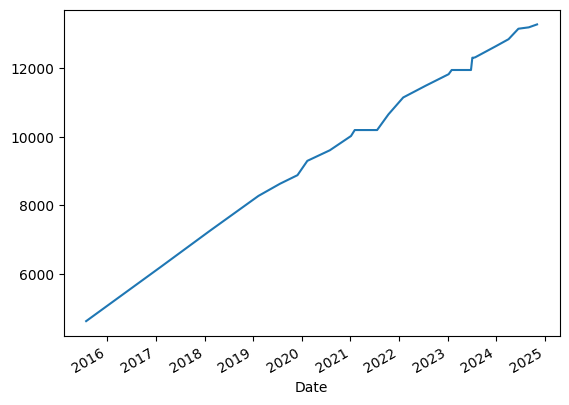

In [6]:
# DELETE

df_forward = df.ffill()
df_forward.Gas.plot()

<Axes: xlabel='Date'>

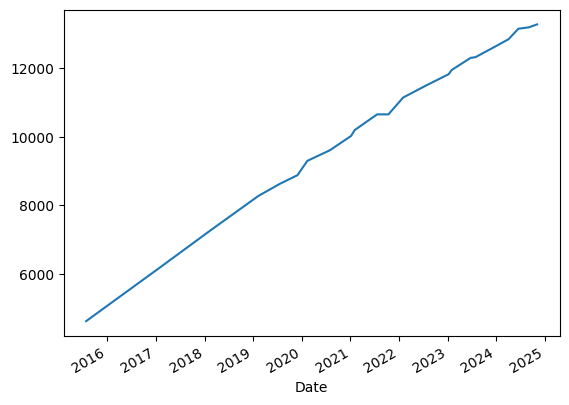

In [7]:
# DELETE

df_back = df.bfill()
df_back.Gas.plot()

Moving on to [moving average](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)... In this case it's a bad filler by the way, can you say why?

<Axes: xlabel='Date'>

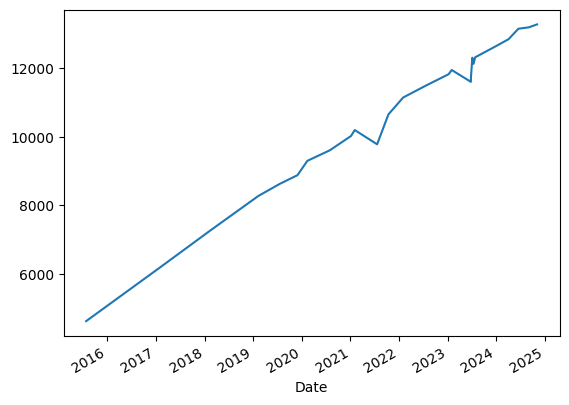

In [8]:
#DELETE

df_moving = df.fillna(df.rolling(5, min_periods=1).mean())
df_moving.Gas.plot()

And finally [interpolating](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html). This requires you to know your data because you need to choose if a polynomial is required, and if so of what order. Let's compare a linear line vs a polynomial of the second and fifth order. (Interpolate three times and graph all the line on one graph.)

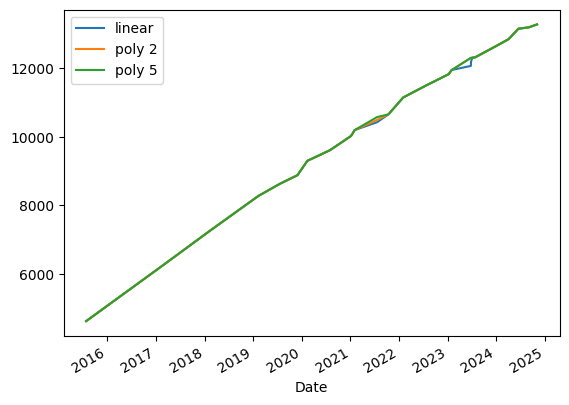

In [9]:
#DELETE

df_inter_linear = df.interpolate(method="linear")
df_inter_poly_2 = df.interpolate(method="polynomial", order=2)
df_inter_poly_5 = df.interpolate(method="polynomial", order=5)

ax = df_inter_linear.Gas.plot()
df_inter_poly_2.Gas.plot(ax=ax)
df_inter_poly_5.Gas.plot(ax=ax)
ax.legend(["linear", "poly 2", "poly 5"])

Maybe zoom in on the years 2021-2023?

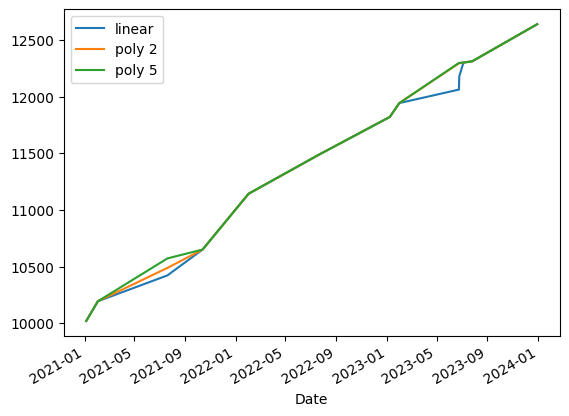

In [10]:
#DELETE

ax = df_inter_linear[(2021 <= df.index.year) & (df.index.year <= 2023)].Gas.plot()
df_inter_poly_2[(2021 <= df.index.year) & (df.index.year <= 2023)].Gas.plot(ax=ax)
df_inter_poly_5[(2021 <= df.index.year) & (df.index.year <= 2023)].Gas.plot(ax=ax)
ax.legend(["linear", "poly 2", "poly 5"])

Which is better? Difficult to say. The real problem is there isn't enough data to distinguish between winter and summer. The gas is only used for heating the house and making hot water, so there should be a difference because we heat the house only in winter, but we use hot water throughout the year. The house is well insulated so I'm pretty pleased with the linearity of this line as it shows that we don't use a lot of extra gas in winter, meaning the cost of heating is low.

But as we said, there simply isn't enough data to make this distinction. If there really was enough data we should have been able to see when I was on holiday (no warm water usage).

So let's leave the dataset as a good example of the 4 methods of filling in blanks in time-series.